**Problem Statement**

Air pollution impacts public health and climate. Using the given air-quality dataset, we want to predict the Air Quality Index (AQI) based on pollutant concentrations.

**Problem Type**

Supervised Machine Learning - Regression Problem

**Target Variable**

AQI (Air Quality Index)

 **Success Metrics**

Since this is regression, we will measure:

MAE – Mean Absolute Error

RMSE – Root Mean Squared Error

R² Score – Goodness of fit

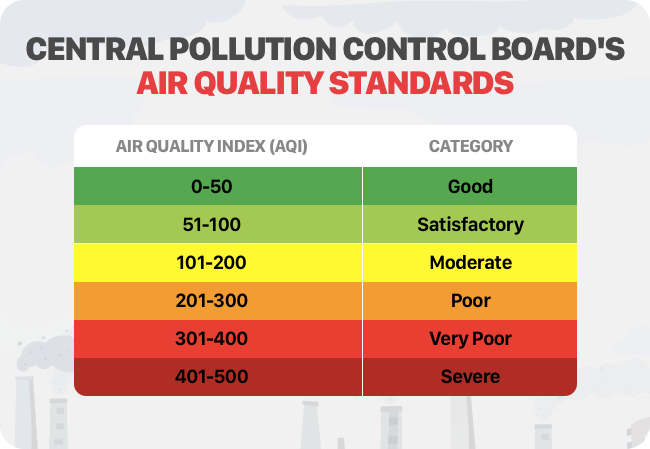

**Import Libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib

**Data Collection**

In [6]:
df = pd.read_excel("Air quality information.xlsx")
df.head()

,last_updated_epoch,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index
0,1693000001,243.7,45.8,1.7,3.1,12.6,18.5,1,2
1,1693000002,240.3,38.3,2.1,2.6,10.7,14.2,1,1
2,1693000003,220.3,57.2,0.6,1.7,16.8,20.7,2,2
3,1693000004,200.3,25.0,1.2,1.1,4.9,6.6,1,1
4,1693000005,257.0,30.8,2.2,1.8,11.4,14.8,1,1


**Data Cleaning**

In [7]:
# Check missing values
print(df.isnull().sum())

# Option 1: fill missing with mean
df = df.fillna(df.mean(numeric_only=True))

# Remove duplicates
df = df.drop_duplicates()

# Convert date columns if any
# df['Date'] = pd.to_datetime(df['Date'])

last_updated_epoch              0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Nitrogen_dioxide    0
air_quality_Sulphur_dioxide     0
air_quality_PM2.5               0
air_quality_PM10                0
air_quality_us-epa-index        0
air_quality_gb-defra-index      0
dtype: int64


**Exploratory Data Analysis**

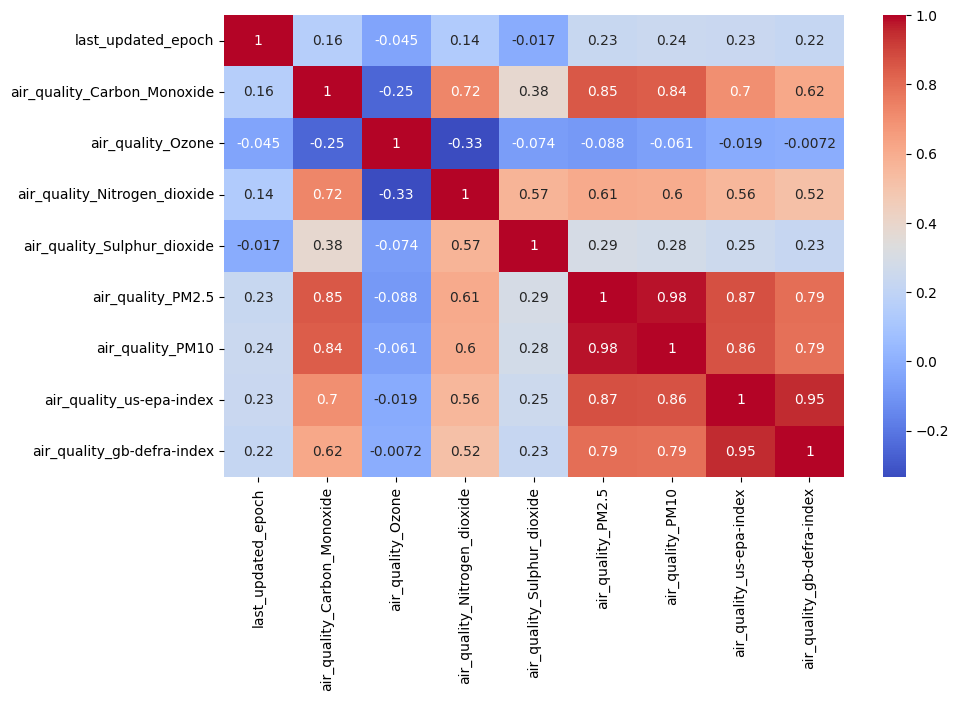

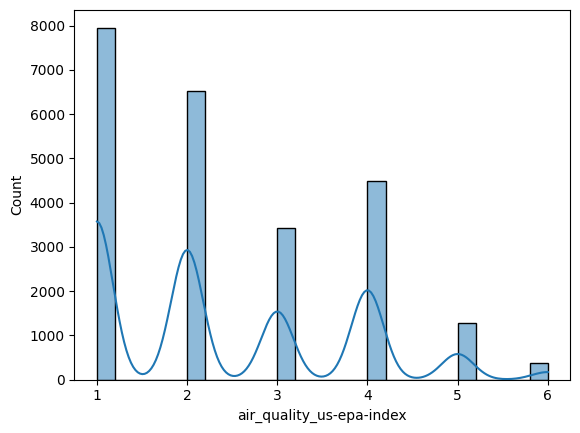

In [8]:
df.describe()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Distribution of AQI
sns.histplot(df['air_quality_us-epa-index'], kde=True)
plt.show()

Strong Positive Correlations (move together):

PM2.5 = PM10 (very strong)

PM2.5 / PM10 = CO

PM2.5 / PM10 = AQI Indexes (US-EPA, GB-DEFRA)

NO₂ = CO

NO₂ = PM2.5 & PM10

AQI Indexes = each other (very strong)

Negative or Weak Correlations (move opposite or unrelated):

Ozone = CO, PM2.5, PM10, NO₂ (weak to negative)

Ozone = AQI indexes (negative/weak)

1. Majority of days fall in AQI Levels 1 & 2

Level 1 (Good) is the highest count

Level 2 (Moderate) is the next highest

Air quality is mostly clean and healthy.

2. Fewer days fall in Levels 3 & 4

Levels 3 (Unhealthy for sensitive groups)

Level 4 (Unhealthy)

These occur but are not very frequent.

3. Very few days reach Levels 5 & 6

Severely unhealthy or hazardous days are rare

Extreme pollution events are uncommon.

Overall Summary

Most of the time, the region experiences good to moderate air quality, with only occasional poor air quality days.

**Feature Engineering**

In [9]:
# Select features & target
X = df.drop("air_quality_us-epa-index", axis=1)
y = df["air_quality_us-epa-index"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Model Building & Training**

In [10]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [11]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

**Model Evaluation**

In [12]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

print("Linear Regression:", evaluate(lr, X_test_scaled, y_test))
print("Random Forest:", evaluate(rf, X_test, y_test))

Linear Regression: (0.26681906661800286, np.float64(0.3185129787210084), 0.943930823671051)
Random Forest: (5.816368923971745e-05, np.float64(0.003754238706789027), 0.9999922104265796)


**Save Best Model**

In [13]:
joblib.dump(rf, "aqi_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

**Model Deployment using Streamlit**

In [14]:
!pip install streamlit

import streamlit as st
import pandas as pd
import joblib

# Load the model and scaler
model = joblib.load("aqi_model.pkl")
scaler = joblib.load("scaler.pkl")

st.title("Real-Time Air Quality Prediction App")

# User Inputs
st.subheader("Enter pollutant values:")

# Example pollutants (modify based on your dataset)
pm25 = st.number_input("PM2.5", 0.0)
pm10 = st.number_input("PM10", 0.0)
no2 = st.number_input("NO2", 0.0)
so2 = st.number_input("SO2", 0.0)
co = st.number_input("CO", 0.0)
o3 = st.number_input("O3", 0.0)

if st.button("Predict AQI"):
    input_data = pd.DataFrame([[pm25, pm10, no2, so2, co, o3]],
                              columns=['PM2.5','PM10','NO2','SO2','CO','O3'])

    # scale numeric features
    input_scaled = scaler.transform(input_data)

    # prediction
    result = model.predict(input_scaled)
    st.success(f"Predicted AQI: {result[0]:.2f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.2 MB/s eta 0:00:00


2025-12-01 15:06:53.805 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.011 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-01 15:06:54.012 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.013 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.015 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.017 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.019 Thread 'MainThread': mi

In [15]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load the model and scaler
model = joblib.load("aqi_model.pkl")
scaler = joblib.load("scaler.pkl")

st.title("Real-Time Air Quality Prediction App")

# User Inputs
st.subheader("Enter pollutant values:")

# Example pollutants (modify based on your dataset)
# Ensure the order and names match those used during model training
pm25 = st.number_input("PM2.5", value=0.0)
pm10 = st.number_input("PM10", value=0.0)
no2 = st.number_input("NO2", value=0.0)
so2 = st.number_input("SO2", value=0.0)
co = st.number_input("CO", value=0.0)
o3 = st.number_input("O3", value=0.0)

if st.button("Predict AQI"):
    # Create a DataFrame for prediction, ensuring column order matches X_train
    # The original X had columns: 'last_updated_epoch', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_gb-defra-index'
    # The user inputs are for PM2.5, PM10, NO2, SO2, CO, O3. We need to reconstruct the full input DataFrame for scaling.
    # For 'last_updated_epoch' and 'air_quality_gb-defra-index', we'll use placeholder values or typical values if available.
    # Assuming 'last_updated_epoch' is not directly used for prediction after scaling, or can be a dummy. Let's use a dummy value.
    # 'air_quality_gb-defra-index' is also an output-like feature, let's assume it's not a direct input for predicting 'air_quality_us-epa-index'.
    # Looking at the original `X` definition: X = df.drop("air_quality_us-epa-index", axis=1).
    # The columns passed to `input_data` in the Streamlit app must match the columns in `X` that were used to train the model, in the correct order.

    # Let's reconstruct the input data based on the columns of X used during training:
    # X.columns: Index(['last_updated_epoch', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_gb-defra-index'], dtype='object')

    # Create a dictionary for the input features
    input_features = {
        'last_updated_epoch': [pd.Timestamp.now().timestamp()], # Placeholder, as it was in original X
        'air_quality_Carbon_Monoxide': [co],
        'air_quality_Ozone': [o3],
        'air_quality_Nitrogen_dioxide': [no2],
        'air_quality_Sulphur_dioxide': [so2],
        'air_quality_PM2.5': [pm25],
        'air_quality_PM10': [pm10],
        'air_quality_gb-defra-index': [0] # Placeholder, as it was in original X, not directly predicted
    }

    # Create the DataFrame with the correct column order from X_train
    original_feature_columns = ['last_updated_epoch', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_gb-defra-index']
    input_df = pd.DataFrame(input_features, columns=original_feature_columns)

    # scale numeric features using the loaded scaler
    input_scaled = scaler.transform(input_df)

    # prediction
    result = model.predict(input_scaled)
    st.success(f"Predicted AQI: {result[0]:.2f}")
    st.write(input_df)
    st.write('Developed by 'Dhivyadharshini.'using streamlit')

Writing app.py


**AQI Monitoring Dashboard**

In [16]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------------------------------------------------------
# PAGE CONFIG
# ---------------------------------------------------------
st.set_page_config(
    page_title="AQI Monitoring Dashboard",
    page_icon="🌫️",
    layout="wide"
)

st.title(" Air Quality Monitoring Dashboard")
st.write("Real-time data analysis, visualization, and AQI prediction.")

# ---------------------------------------------------------
# LOAD MODEL & SCALER
# ---------------------------------------------------------
try:
    model = joblib.load("aqi_model.pkl")
    scaler = joblib.load("scaler.pkl")
    st.success("Model Loaded Successfully!")
except:
    st.warning("Model not found. Upload aqi_model.pkl & scaler.pkl to enable prediction.")

# ---------------------------------------------------------
# SIDEBAR – FILE UPLOAD
# ---------------------------------------------------------
st.sidebar.header("Upload Air Quality Dataset")
uploaded_file = st.sidebar.file_uploader("Upload Excel/CSV File", type=["xlsx", "csv"])

if uploaded_file:
    # LOAD DATA
    if uploaded_file.name.endswith(".xlsx"):
        df = pd.read_excel(uploaded_file)
    else:
        df = pd.read_csv(uploaded_file)

    st.subheader(" Dataset Preview")
    st.dataframe(df.head())

    # ---------------------------------------------------------
    # SUMMARY
    # ---------------------------------------------------------
    st.subheader(" Dataset Summary")
    c1, c2 = st.columns(2)

    with c1:
        st.write("### Shape")
        st.write(df.shape)

    with c2:
        st.write("### Missing Values")
        st.write(df.isnull().sum())

    st.write("### Descriptive Statistics")
    st.dataframe(df.describe())

    # ---------------------------------------------------------
    # EDA: HEATMAP
    # ---------------------------------------------------------
    st.subheader(" Correlation Heatmap")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", ax=ax)
    st.pyplot(fig)

    # ---------------------------------------------------------
    # EDA: POLLUTANT COMPARISON
    # ---------------------------------------------------------
    st.subheader(" Pollutant Trends")

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    pollutant = st.selectbox("Select a pollutant to visualize", numeric_cols)

    fig2, ax2 = plt.subplots(figsize=(10, 4))
    sns.lineplot(data=df, y=pollutant, x=df.index, ax=ax2)
    st.pyplot(fig2)

    # ---------------------------------------------------------
    # PAIRPLOT (INTERACTIVE)
    # ---------------------------------------------------------
    st.subheader(" Pollutant Relationship Plot")

    selected_cols = st.multiselect(
        "Select columns for comparison",
        numeric_cols,
        default=numeric_cols[:4]
    )

    if len(selected_cols) > 1:
        fig3 = sns.pairplot(df[selected_cols])
        st.pyplot(fig3)

    # ---------------------------------------------------------
    # REAL-TIME AQI PREDICTION PANEL
    # ---------------------------------------------------------
    st.subheader(" Real-Time AQI Prediction")

    placeholder_cols = [col for col in numeric_cols if col.lower() != "aqi"]

    values = {}
    for col in placeholder_cols:
        values[col] = st.number_input(f"Enter {col}", min_value=0.0, value=0.0)

    if st.button("Predict AQI"):
        if "model" in locals() and "scaler" in locals():
            # Convert dict → DataFrame
            input_df = pd.DataFrame([values])

            try:
                input_scaled = scaler.transform(input_df)
                pred = model.predict(input_scaled)
                st.success(f"Predicted AQI: {pred[0]:.2f}")
            except Exception as e:
                st.error(f"Error in prediction: {e}")
        else:
            st.error("Model not loaded. Please upload model files.")

else:
    st.warning("Please upload a dataset to begin the analysis.")

2025-12-01 15:06:54.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.197 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.198 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.199 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.202 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:06:54.251 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [17]:
API_KEY = "16992bbc66040081eaab17c4d7c577ee9948d4ed"

In [20]:
import requests

st.subheader("🌎 Real-Time AQI from Live API")

API_KEY = "16992bbc66040081eaab17c4d7c577ee9948d4ed"   # <<--- Replace with your key

city = st.text_input(" Chennai, Delhi, Mumbai, Bangalore")

def get_live_aqi(city):
    """
    Fetch real-time AQI from AQICN API.
    API Format: https://api.waqi.info/feed/{city}/?token=YOUR_TOKEN
    """
    url = f"https://api.waqi.info/feed/{city}/?token={API_KEY}"
    response = requests.get(url)

    if response.status_code != 200:
        return None, "API Error: Unable to connect"

    data = response.json()

    if data["status"] != "ok":
        return None, "City not found or API limit reached"

    aqi = data["data"]["aqi"]
    pollutants = data["data"]["iaqi"]

    pollutant_values = {}
    for key, val in pollutants.items():
        pollutant_values[key.upper()] = val.get("v", None)

    return aqi, pollutant_values


# When user clicks the button
if st.button("Fetch Live AQI"):
    if city.strip() == "":
        st.error("Please enter a valid city name.")
    else:
        aqi, pollutant_values = get_live_aqi(city)

        if aqi is None:
            st.error(pollutant_values)  # error message
        else:
            st.success(f"Real-Time AQI in {city}: {aqi}")

            # Health Meaning
            if aqi <= 50:
                level = "Good 😊"
            elif aqi <= 100:
                level = "Moderate 🙂"
            elif aqi <= 150:
                level = "Unhealthy for Sensitive Groups 😐"
            elif aqi <= 200:
                level = "Unhealthy 😷"
            elif aqi <= 300:
                level = "Very Unhealthy 🤒"
            else:
                level = "Hazardous ☠️"

            st.write(f"**Air Quality Level:** {level}")

            # Show pollutants
            st.write("### Pollutant Breakdown")
            st.json(pollutant_values)

            # Plot pollutants
            if pollutant_values:
                fig, ax = plt.subplots()
                ax.bar(pollutant_values.keys(), pollutant_values.values())
                ax.set_title(f"Pollutant Levels in {city}")
                ax.set_ylabel("Concentration")
                st.pyplot(fig)

2025-12-01 15:09:33.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:09:33.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:09:33.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:09:33.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:09:33.229 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:09:33.232 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:09:33.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 15:09:33.239 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [21]:
cd path/to/your/project

[Errno 2] No such file or directory: 'path/to/your/project'
/content
